# Set up the environment

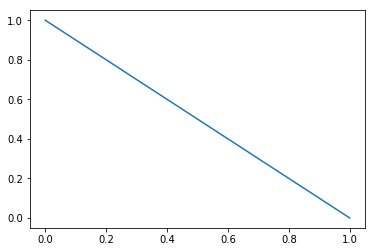

(-75, -56)
Import of badexp.ADEXPBackend failed due to:
No module named 'neuronunit.models.backends.badexp'
Import of bhh.BHHBackend failed due to:
No module named 'neuronunit.models.backends.bhh'
Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


WARNING    /Users/rjjarvis/git/safe/neuronunit/neuronunit/unit_test/working/hide_imports.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.plot([0,1],[1,0])
plt.show()
import hide_imports
from neuronunit.optimisation.optimization_management import inject_and_plot_model


# Design simulated data tests

In [2]:
def jrt(use_test,backend):
    use_test = hide_imports.TSD(use_test)
    use_test.use_rheobase_score = True
    edges = hide_imports.model_parameters.MODEL_PARAMS[backend]

    OM = hide_imports.OptMan(use_test,\
                backend=backend,\
                boundary_dict=edges,\
                protocol={'allen': False, 'elephant': True})

    return OM



In [3]:
test_frame = hide_imports.get_neab.process_all_cells()
test_frame.pop('Olfactory bulb (main) mitral cell',None)
stds = {}
for k,v in hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6']).items():
    temp = hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6'])[k]
    stds[k] = temp.observation['std']
    print((temp.name,temp.observation))
OMObjects = []
backends = ["RAW"]
import copy
cloned_tests = copy.copy(test_frame['Neocortex pyramidal cell layer 5-6'])
import copy
for b in backends:        
    OM = jrt(cloned_tests,b)
    OMObjects.append(OM)
rt_outs = []

('RheobaseTest', {'mean': array(213.84958333) * pA, 'std': array(170.45245472) * pA, 'n': 32})
('InputResistanceTest', {'mean': array(120.67207364) * Mohm, 'std': array(77.63316083) * Mohm, 'n': 86})
('TimeConstantTest', {'mean': array(15.73424242) * ms, 'std': array(7.31162637) * ms, 'n': 33})
('CapacitanceTest', {'mean': array(150.58416667) * pF, 'std': array(139.68388463) * pF, 'n': 12})
('RestingPotentialTest', {'mean': array(-68.24814346) * mV, 'std': array(6.53234788) * mV, 'n': 79})
('InjectedCurrentAPAmplitudeTest', {'mean': array(80.43510204) * mV, 'std': array(12.74880304) * mV, 'n': 49})
('InjectedCurrentAPThresholdTest', {'mean': array(-42.73572327) * mV, 'std': array(8.04073233) * mV, 'n': 53})


In [4]:
for OM in OMObjects:
   print(OM.backend)
   x= {k:v for k,v in OM.tests.items() if 'mean' in v.observation.keys() or 'value' in v.observation.keys()}
   cloned_tests = copy.copy(OM.tests)
   OM.tests = hide_imports.TSD(cloned_tests)
   rt_out = OM.simulate_data(OM.tests,OM.backend,OM.boundary_dict)
   #print(rt_out)


RAW
RheobaseTest
{'value': array(324.90897775) * pA} is this called?
InputResistanceTest
{'value': array(21560059.22432768) * kg*m**2/(s**3*A**2)} is this called?
TimeConstantTest
{'value': array(2197.64617532) * ms} is this called?
CapacitanceTest
{'value': array(1.01931361e-07) * s**4*A**2/(kg*m**2)} is this called?
RestingPotentialTest
{'mean': array(-70.10789875) * mV, 'std': array(2.84217094e-14) * mV} is this called?
InjectedCurrentAPAmplitudeTest
{'value': array(62.78040887) * mV, 'mean': array(62.78040887) * mV, 'std': array(0.) * mV, 'n': 1} is this called?
InjectedCurrentAPThresholdTest
{'mean': array(-17.99770263) * mV, 'std': array(0.) * mV, 'n': 1} is this called?
Random simulated data tests made


In [5]:
penultimate_tests = hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6'])
for k,v in penultimate_tests.items():
    temp = penultimate_tests[k]

    v = rt_out[1][k].observation
    v['std'] = stds[k]
simulated_data_tests = hide_imports.TSD(penultimate_tests)

# Show what the randomly generated target waveform the optimizer needs to find actually looks like

(AnalogSignal with 1 channels of length 130000; units mV; datatype float64 
 sampling rate: 100.0
 time: 0.0 to 1.3,
 <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>)

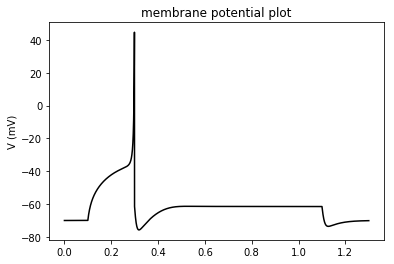

In [6]:
target = rt_out[0]
target.rheobase
inject_and_plot_model(target)

# Commence optimization of models on simulated data sets

# first lets just optimize over single objective functions at a time.

In [7]:
ga_out_rh = hide_imports.TSD([simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=10,NGEN=10)
opt_rh = ga_out_rh['pf'][0].dtc
opt_rh.obs_preds

,RheobaseTest,total
observations,324.9089777469635 pA,NaN
predictions,325.0269412994385 pA,NaN
scores,0.000552338,0.000552


In [8]:
ga_out_time = hide_imports.TSD([simulated_data_tests["TimeConstantTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=10,NGEN=10)
opt_time = ga_out_time['pf'][0].dtc
opt_time.obs_preds

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)



,TimeConstantTest,total
observations,2197.6461753224035 ms,NaN
predictions,2211.919531592609 ms,NaN
scores,2.97748,2.97748


In [9]:
both = hide_imports.TSD([simulated_data_tests["TimeConstantTest"],simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=20,NGEN=5)
both = both['pf'][0].dtc
both.obs_preds

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)



,TimeConstantTest,RheobaseTest,total
observations,2197.6461753224035 ms,324.9089777469635 pA,NaN
predictions,1964.9461000314323 ms,323.57919216156006 pA,NaN
scores,inf,0.00624409,inf


In [10]:
three = hide_imports.TSD([simulated_data_tests["InjectedCurrentAPAmplitudeTest"],simulated_data_tests["TimeConstantTest"],simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=6)


WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)



In [11]:
three = three['pf'][0].dtc
three.obs_preds

,InjectedCurrentAPAmplitudeTest,TimeConstantTest,RheobaseTest,total
observations,62.780408867400254 mV,2197.6461753224035 ms,324.9089777469635 pA,NaN
predictions,64.75922266499357 mV,3394.7097944691764 ms,326.6723155975342 pA,NaN
scores,0.131646,inf,0.00828826,inf



# What have we learned? 
* It seems like for this neural model optimization problem, when acting under multiobjective constraints bigger population size is more useful than large NGEN.
* This probably comes down to our design choices. If the genes initially sample a large amount of the hypervolume, it takes a long time for the genes to be motivated explore unsampled regions, so its best to make the initial exploration a widely spanned sampling of all the dimensions a large population size ensures this.


# Now lets test all the objectives together?


In [12]:
ga_out = simulated_data_tests.optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=15)
opt = ga_out['pf'][0].dtc

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
  category=OptimizeWarning)

WARNING    /anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of 

In [13]:
front = [ind.dtc for ind in ga_out['pf']][0:9]

In [14]:
opt.rheobase


array(200.35838485) * pA

(AnalogSignal with 1 channels of length 130000; units mV; datatype float64 
 sampling rate: 100.0
 time: 0.0 to 1.3,
 <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>)

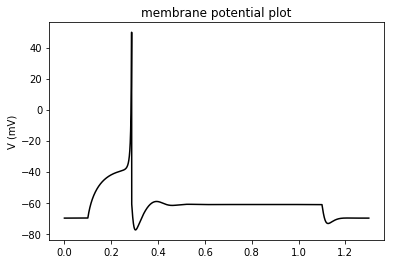

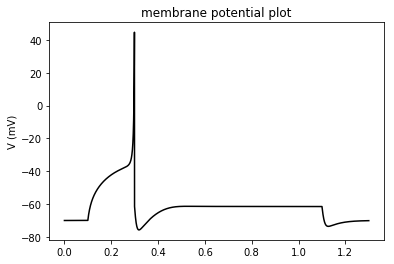

In [15]:
inject_and_plot_model(opt)
inject_and_plot_model(target)


In [16]:
opt.obs_preds

,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,324.9089777469635 pA,21560059.224327683 kg*m**2/(s**3*A**2),2197.6461753224035 ms,1.0193136078414152e-07 s**4*A**2/(kg*m**2),-70.10789875208918 mV,62.780408867400254 mV,-17.997702634791807 mV,NaN
predictions,200.358384847641 pA,34199274.34496941 kg*m**2/(s**3*A**2),3.4439756155772017 ms,1.0070317810950274e-10 s**4*A**2/(kg*m**2),-69.94102817429204 mV,68.0551114606931 mV,-18.20469992461087 mV,NaN
scores,0.765806,0.138492,inf,inf,0.0205905,0.38704,0.020752,inf


In [17]:
model = opt.dtc_to_model()
score = simulated_data_tests['TimeConstantTest'].judge(model)
pred = simulated_data_tests['TimeConstantTest'].prediction
print(pred)

{'value': array(3.44397562) * ms}


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

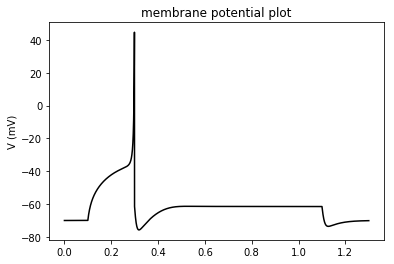

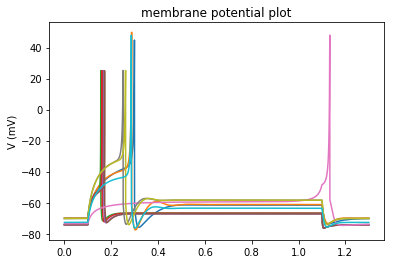

In [18]:
from neuronunit.optimisation.optimization_management import check_match_front
#check_binary_match(opt,target)

inject_and_plot_model(target)
check_match_front(target,front)




In [19]:
import pandas as pd
frame = pd.DataFrame([opt.attrs,target.attrs],index=["solution","target"])
frame

,C,a,b,c,k,vPeak,vr,vt,dt,Iext,d
solution,200.000000,0.028989,14.988391,-59.895593,0.700001,49.850412,-69.941028,-49.923050,0.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
target,259.073692,0.012436,18.759579,-60.652943,0.968031,44.782706,-70.107899,-41.788182,0.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",86.912675


# Interpretation
Looking above at the observation/prediction table. The agreement is starting to look good for many tests
but the waveform matching is still bad. Perhaps the optimizer just needs more computation.
Fortunately its possible to initialize an optimizer with genes which are that are the best and diverse solutions to a previous optimizers search.

It will be interesting to know if adding in another 10 generations of search will improve optimizer outputs.

In [ ]:
ga_revised = simulated_data_tests.optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=6,seed_pop=ga_out['pf'][0:24])
ga_revised = ga_out['pf'][0].dtc

In [ ]:
opt = ga_revised['pf'][0].dtc

##### 